In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/analysis.csv')

In [3]:
import hgtk, os, re
from tqdm.notebook import tqdm

In [4]:
import MeCab
import ast
mecab=MeCab.Tagger()
mecab.parse('매캡 테스트용 문장입니다')

'매\tMM,~명사,F,매,*,*,*,*\n캡\tXPN,*,T,캡,*,*,*,*\n테스트\tNNG,행위,F,테스트,*,*,*,*\n용\tXSN,*,T,용,*,*,*,*\n문장\tNNG,*,T,문장,*,*,*,*\n입니다\tVCP+EC,*,F,입니다,Inflect,VCP,EC,이/VCP/*+ᄇ니다/EC/*\nEOS\n'

In [5]:
def parse_text(text):
    bucket = []
    start = 0
    pattern = re.compile(".*\t[A-Z]+") 
    for token, pos in  [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]:
        if start == 0:
            lspace = False
        elif text[start] == ' ':
            lspace = True
        else:
            lspace = False
        start = text.find(token, start)
        end = start + len(token)
        bucket.append((token, pos, lspace, start, end))
        start = end
    return bucket
def apply_noun_ext(df):
    total = ast.literal_eval(df['advice_total'])
    detail = ast.literal_eval(df['advice_detail'])
    text = ' '.join(total)+ ' '.join(detail)
    clean_text = re.sub('\[지원자\]', '', text)
    result = noun_ext(parse_text(clean_text))
    return result

def check_noun(cand):
    if len(re.findall('[^가-힣a-zA-Z0-9+]', cand)) > 0:
        return False
    else:
        return True

In [6]:
def noun_ext(parsed_text):
    global stopwords
    global one_list
    noun_bucket = []
    bi_bucket = []
    tri_bucket = []
    last_last_add = None
    last_add = None
    last_lspace = None
    for ichunk in parsed_text:
        token = ichunk[0]
        pos = ichunk[1]
        lspace = ichunk[2]
        add = False
        if pos == 'NNG': 
            if check_noun(token) == True: 
                if token not in stopwords:
                    if len(token) > 1: 
                        add = True
                    elif token in one_list:
                        add = True
        if pos == 'NNP': 
            if token not in stopwords:
                if len(token) > 1:
                    add = True
                elif token in one_list:
                    add = True
                    
        if add == True:
            if (last_add == True) and (lspace == False) and (len(noun_bucket) > 0):
                bi_bucket.append('|'.join([noun_bucket[-1], token]))
            if (last_add == True) and (last_last_add == True) and (lspace == False) and \
            (last_lspace == False) and (len(noun_bucket) > 1):
                tri_bucket.append('|'.join([noun_bucket[-2], noun_bucket[-1], token]))
            noun_bucket.append(token)
        last_lspace = lspace
        last_last_add = last_add
        last_add = add
    return pd.Series((noun_bucket, bi_bucket, tri_bucket))

In [7]:
one_list = list('젤펄물향색립손짱굳양톤물티밤코빛붓굿돈팩맥맛감웜집샵끈선속밖겉봄반광팁샷솔볼폼딥입펜발템갑값'
            '똥룩꿀떡존몸핏땀핫옆꽃액칠금쿨차밥병솜망폰링통옷목팔숱배살털컬홈짝뷰')

In [8]:
tqdm.pandas()

In [9]:
stopwords = ['전반','지원자','직무', '내용','부분','항목','회사','지원', '소개서','제시','관련','질문','작성']
df[['keywords','bigrams','trigrams']] = df[['advice_total','advice_detail']].fillna('').progress_apply(apply_noun_ext, axis=1)

  0%|          | 0/3434 [00:00<?, ?it/s]

In [10]:
from collections import Counter
task_list = ['사무·총무·법무','기획·전략·경영','응용프로그래머','전기·전자·제어','영업관리·지원·영업기획','생산관리·공정관리·품질관리']
word_df=pd.DataFrame()
for task in task_list:
    c = Counter()
    c_b = Counter()
    c_t = Counter()

    for i,row in df[(df['task']==task)].iterrows():
        keywords = row['keywords']
        c.update(keywords)

    word_df = pd.concat([word_df,pd.DataFrame(c.most_common(20))], axis=1)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='AppleGothic')

In [23]:
df[(df['task']=='사무·총무·법무')][[
    'univ','degree','point_ratio','toeic','toeic_speaking','act_school', 
    'act_society', 'act_volunteer', 'act_oversea', 
    'act_intern', 'act_prize', 'act_club', 'lang']]

,univ,degree,point_ratio,toeic,toeic_speaking,act_school,act_society,act_volunteer,act_oversea,act_intern,act_prize,act_club,lang
4,지방4년,산업공학과,0.744444,810.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN
26,지방4년,국제통상학과,0.853333,NaN,6.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
32,지방4년,수학과,0.755556,730.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN
37,서울4년,국제통상학전공,0.753333,NaN,5.0,NaN,1.0,1.0,1.0,2.0,NaN,1.0,NaN
40,서울4년,영어영문학과,0.913333,950.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,고졸,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3368,수도권4년,법학과,0.822222,805.0,6.0,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN
3378,고졸,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3392,지방4년,경제통상학부,0.866667,930.0,7.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN


### 학생 전공별 자소서 분포 

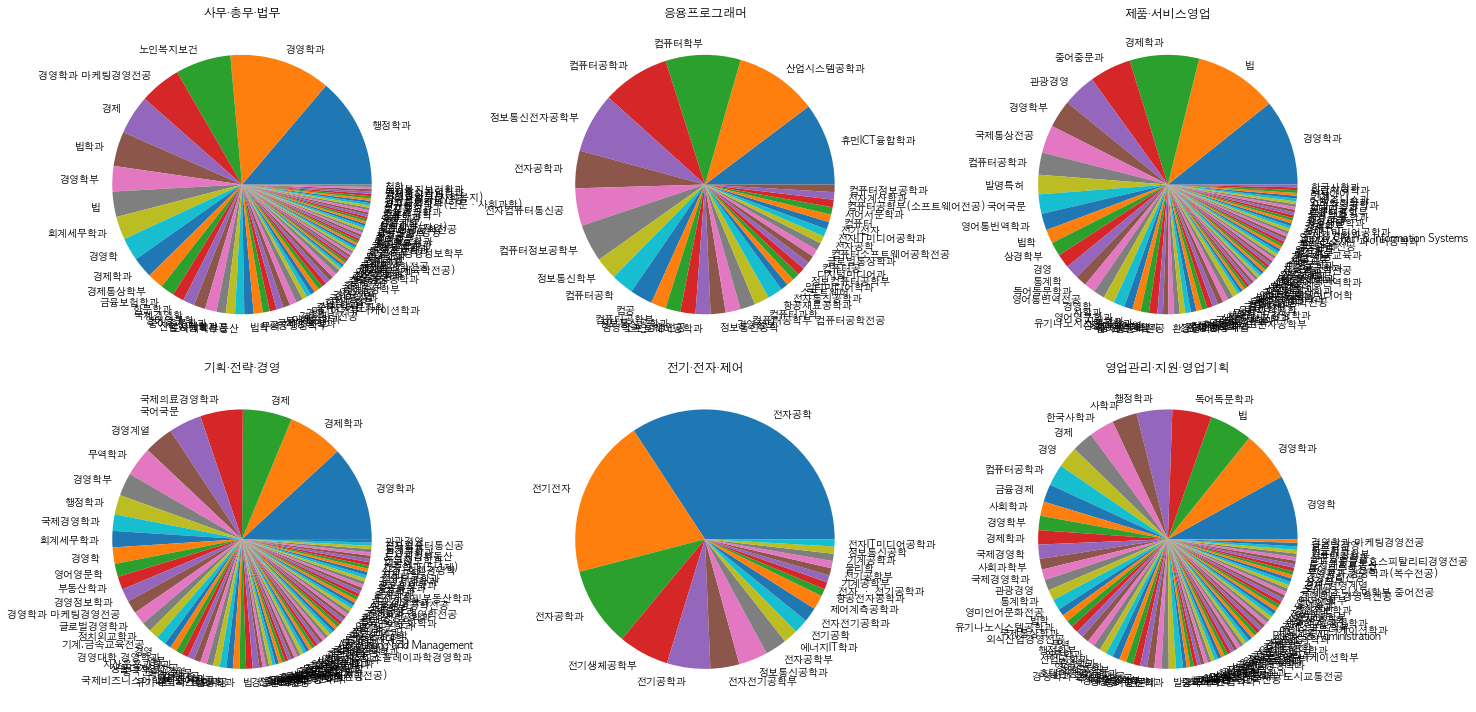

In [15]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['degree'].value_counts()
    ax[row][col].pie(tmp, labels=tmp.index)
    ax[row][col].set(title=name, aspect='equal')

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

### 학점/학점총점 히스토그램

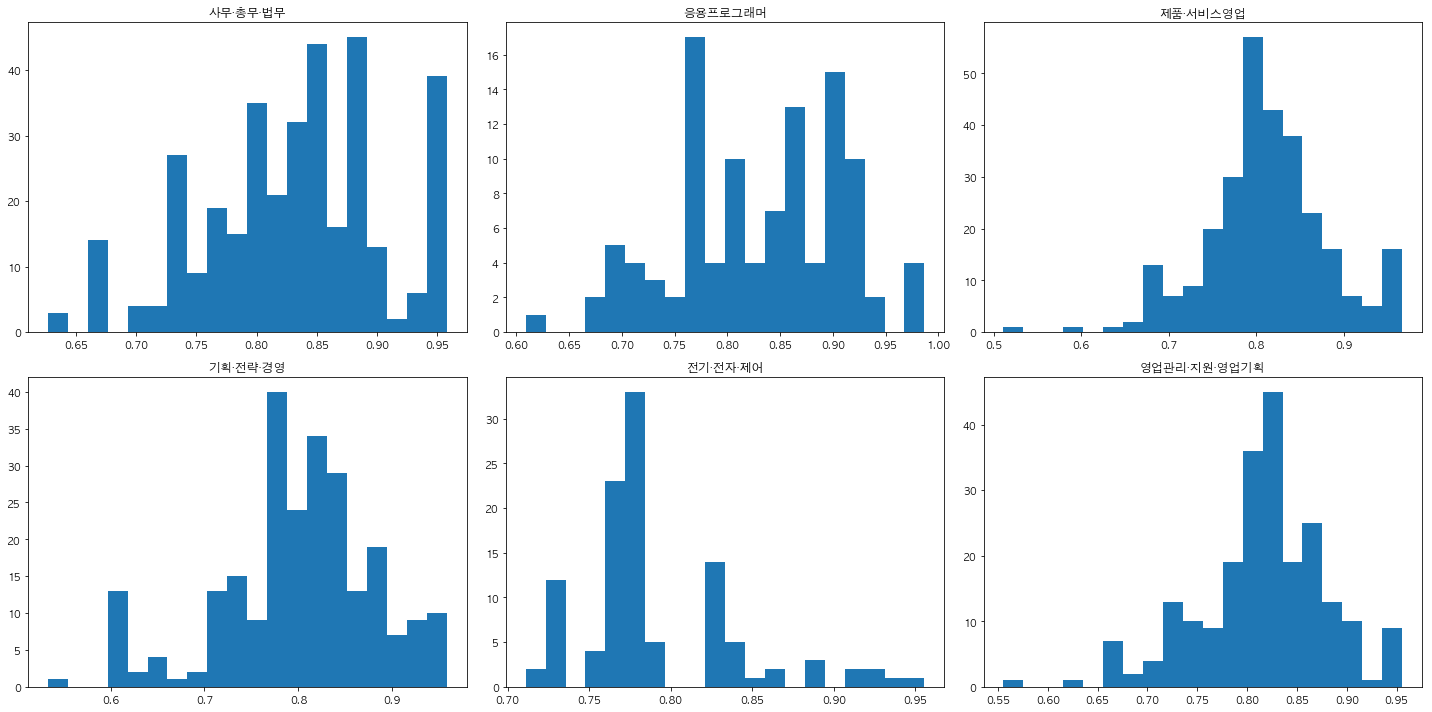

In [16]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['point_ratio'].dropna() #.plot.hist(bins=20, title="학점 비율")
    ax[row][col].hist(tmp,  bins=20, histtype='bar', fill=True)
    ax[row][col].set(title=name)

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()


### 직군별 토익점수 히스토그램 

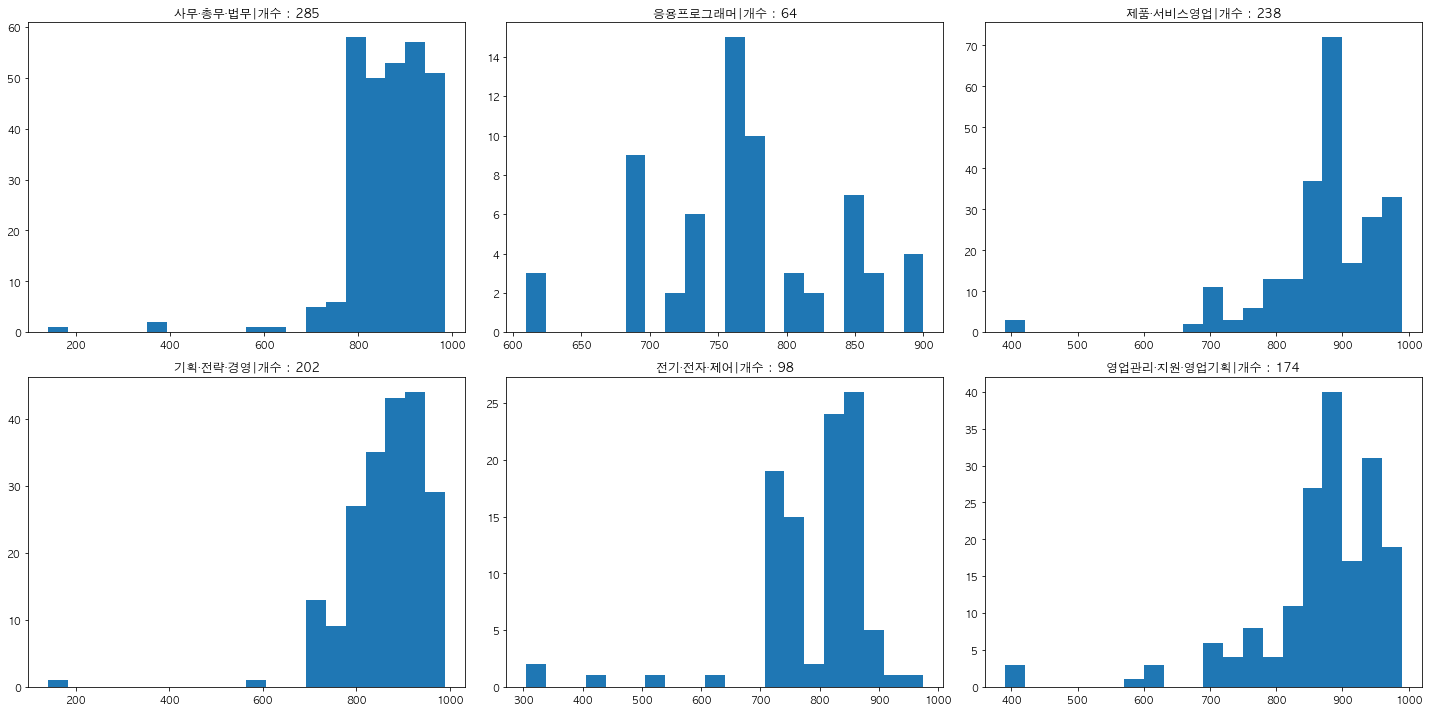

In [17]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['toeic'].dropna() #.plot.hist(bins=20, title="학점 비율")
    ax[row][col].hist(tmp,  bins=20, histtype='bar', fill=True)
    ax[row][col].set(title=name + '|개수 : ' + str(len(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()


### 토익 스피킹 레벨별 분포

TypeError: str() argument 2 must be str, not int

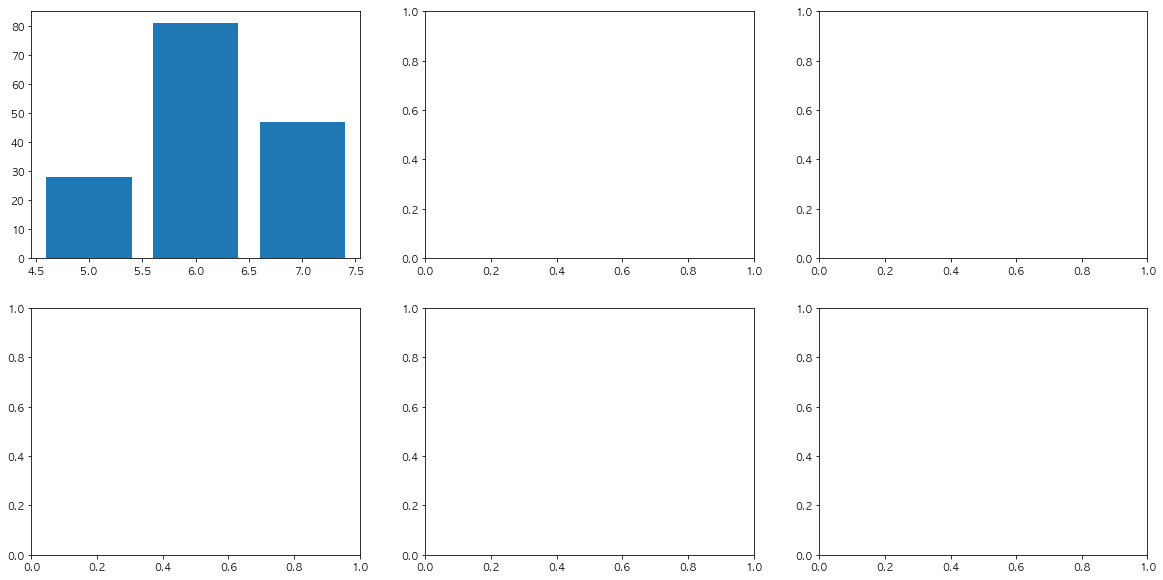

In [39]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['toeic_speaking'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)) +' | 비율 : ' + str(sum(tmp)/len(df[(df['task']==name)]),2))
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()


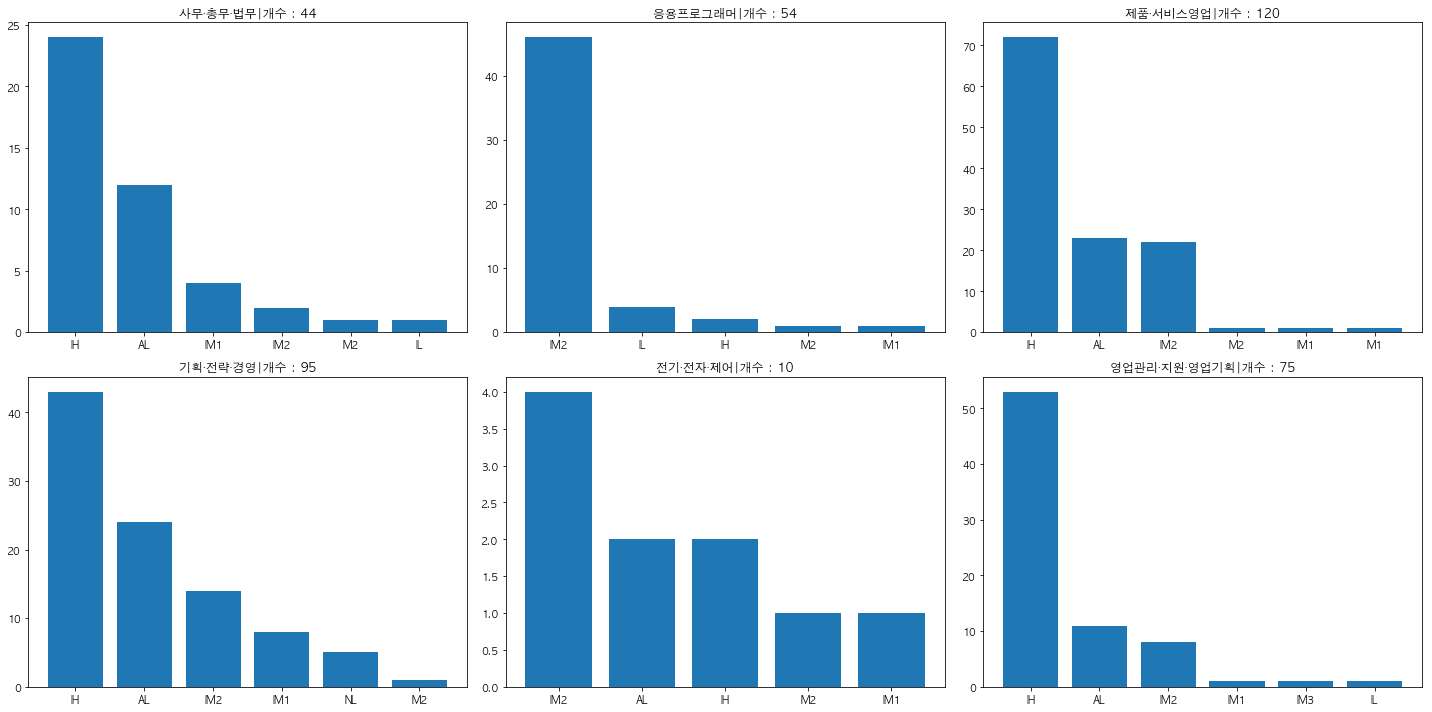

In [21]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['opic'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

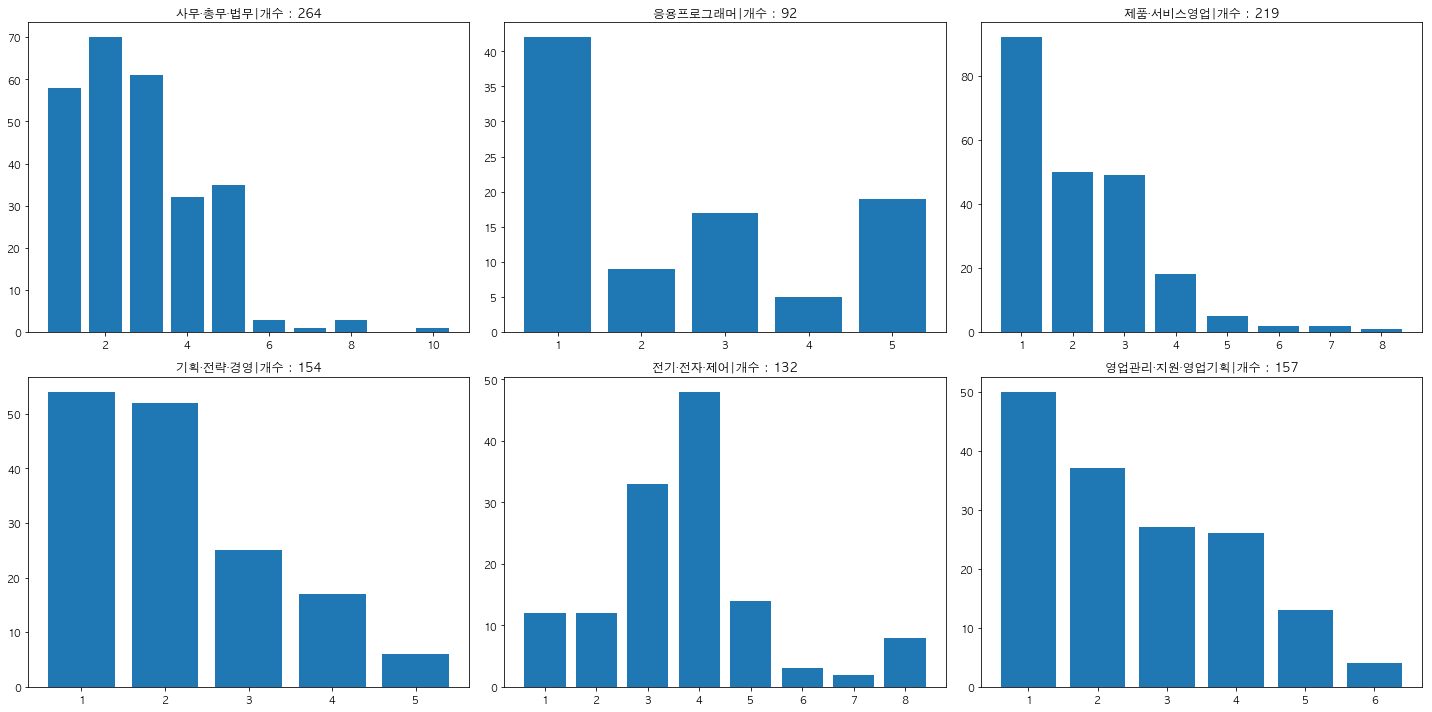

In [22]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['cert_num'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

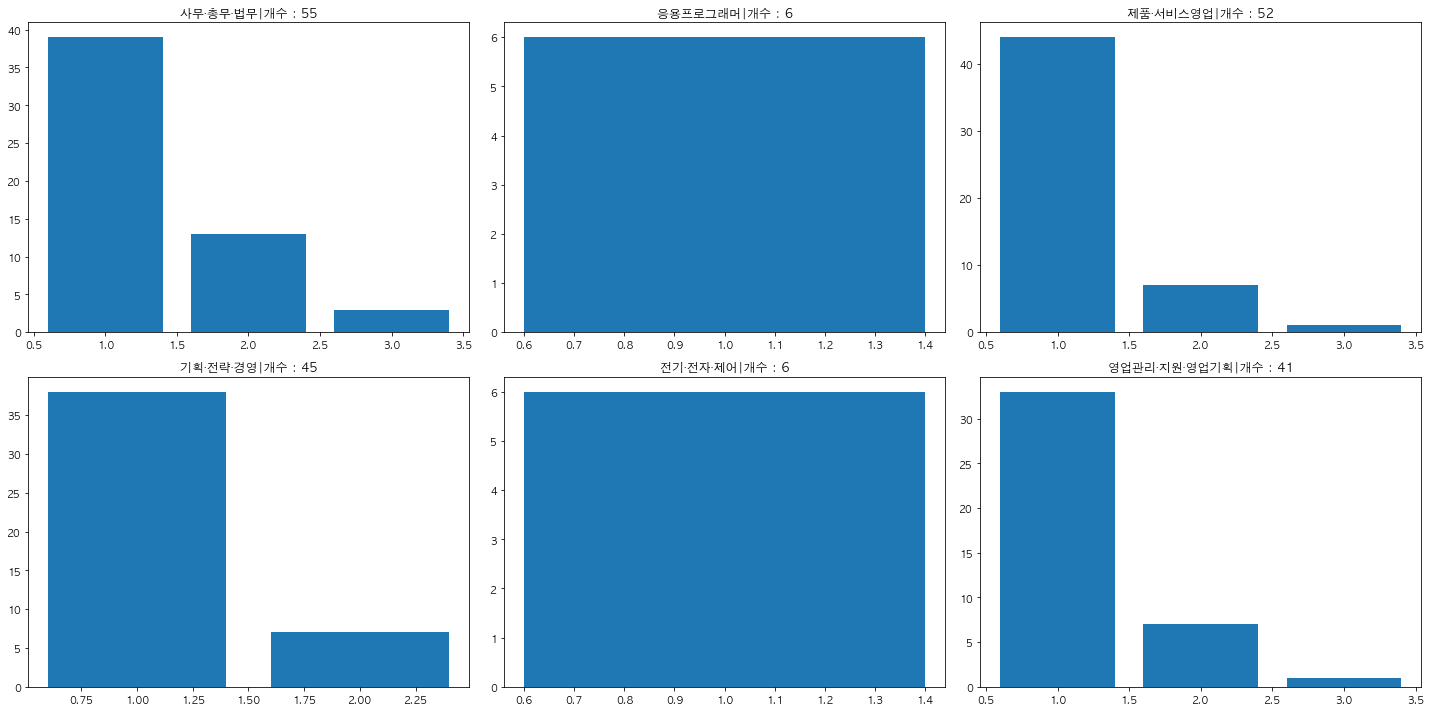

In [24]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_school'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

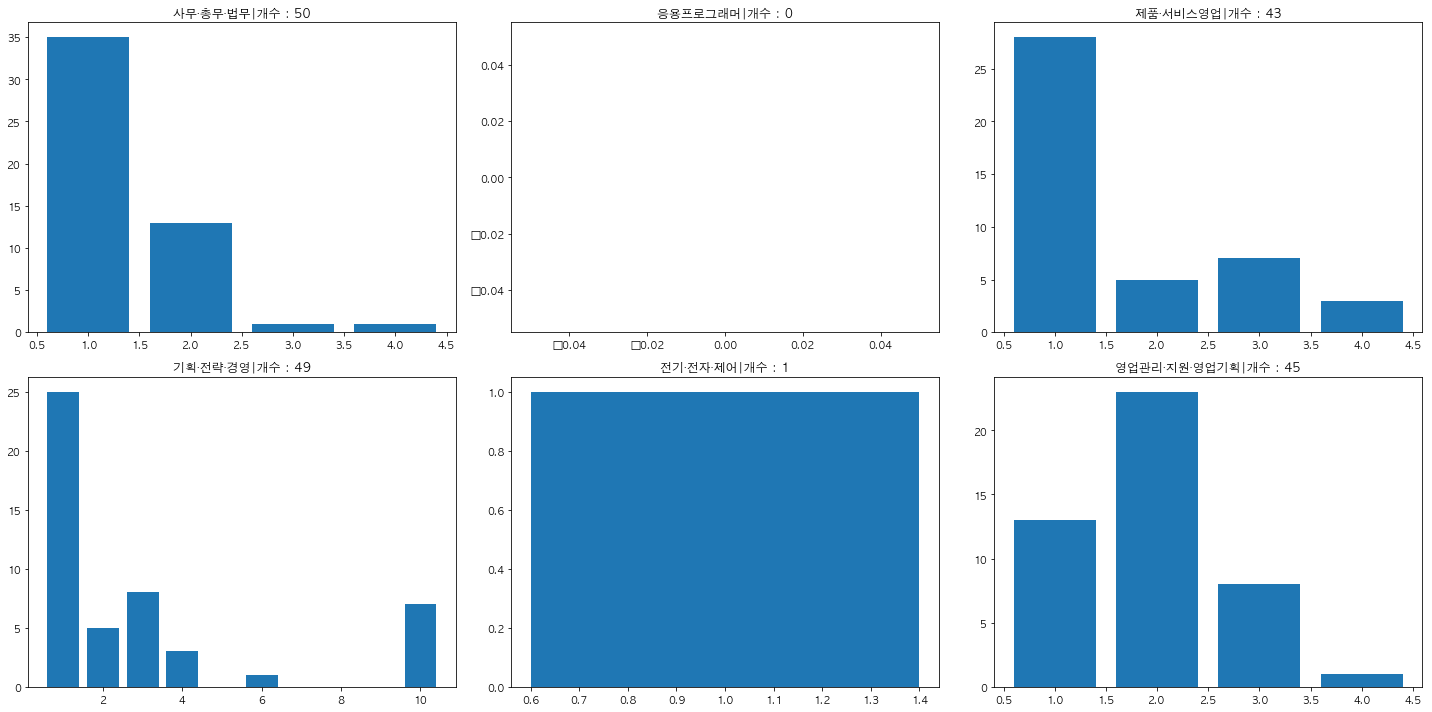

In [27]:
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_society'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

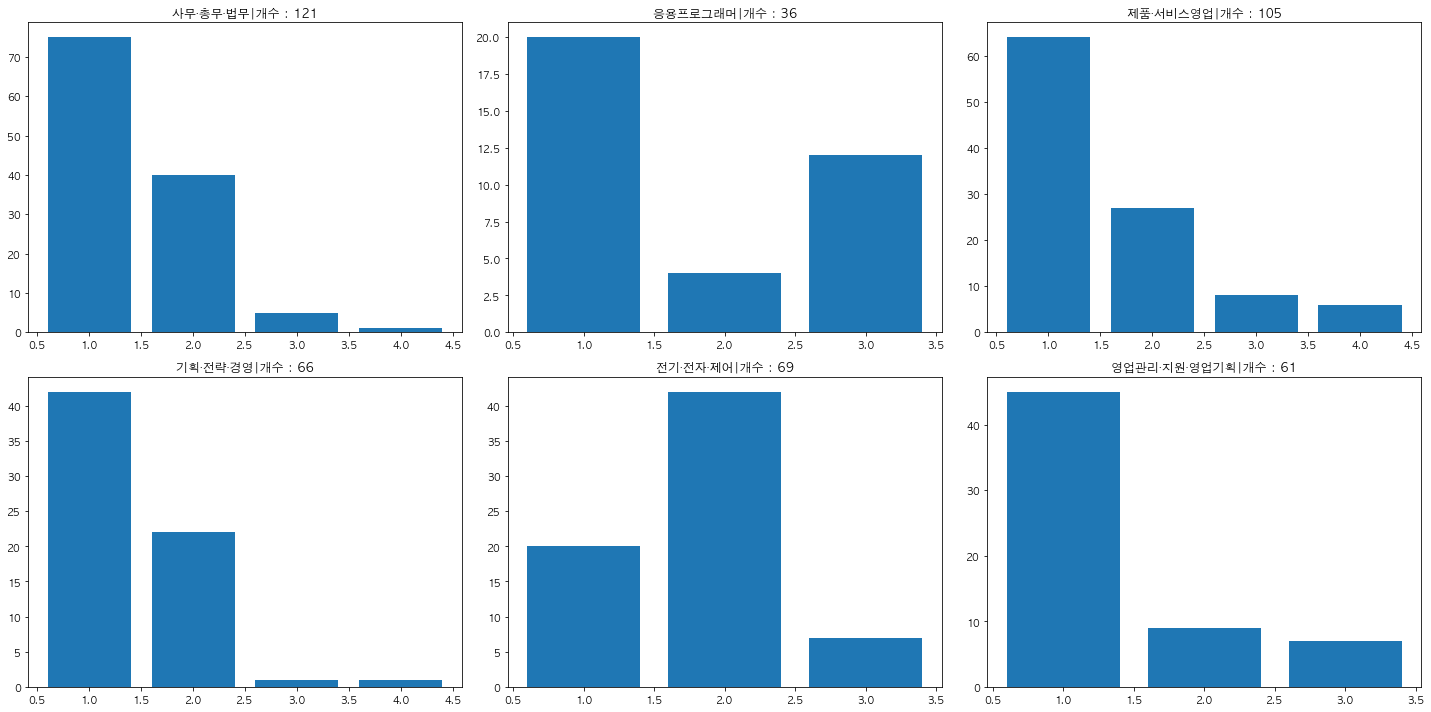

In [28]:
# 'act_society', 'act_volunteer', 'act_oversea', 
#     'act_intern', 'act_prize', 'act_club', 'lang']]
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_volunteer'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

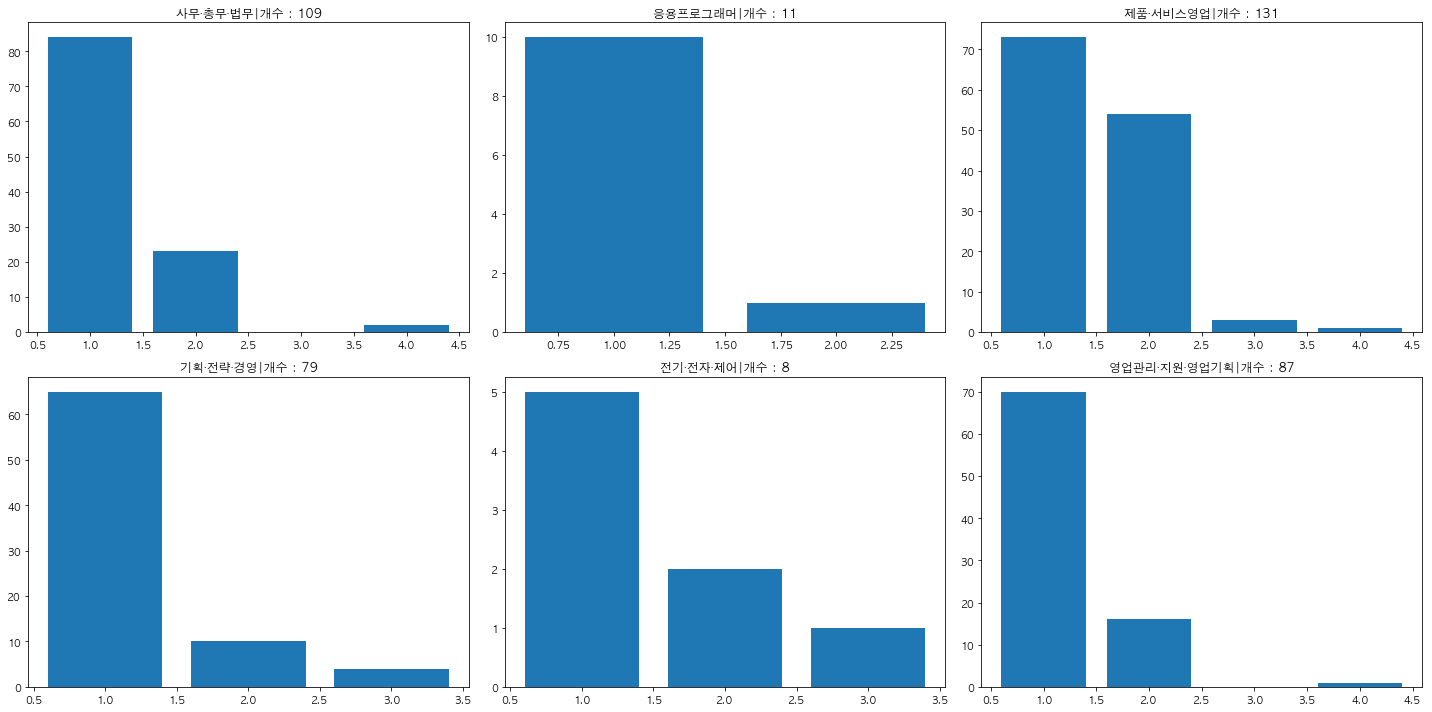

In [29]:
# 'act_society', 'act_volunteer', 'act_oversea', 
#     'act_intern', 'act_prize', 'act_club', 'lang']]
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_oversea'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

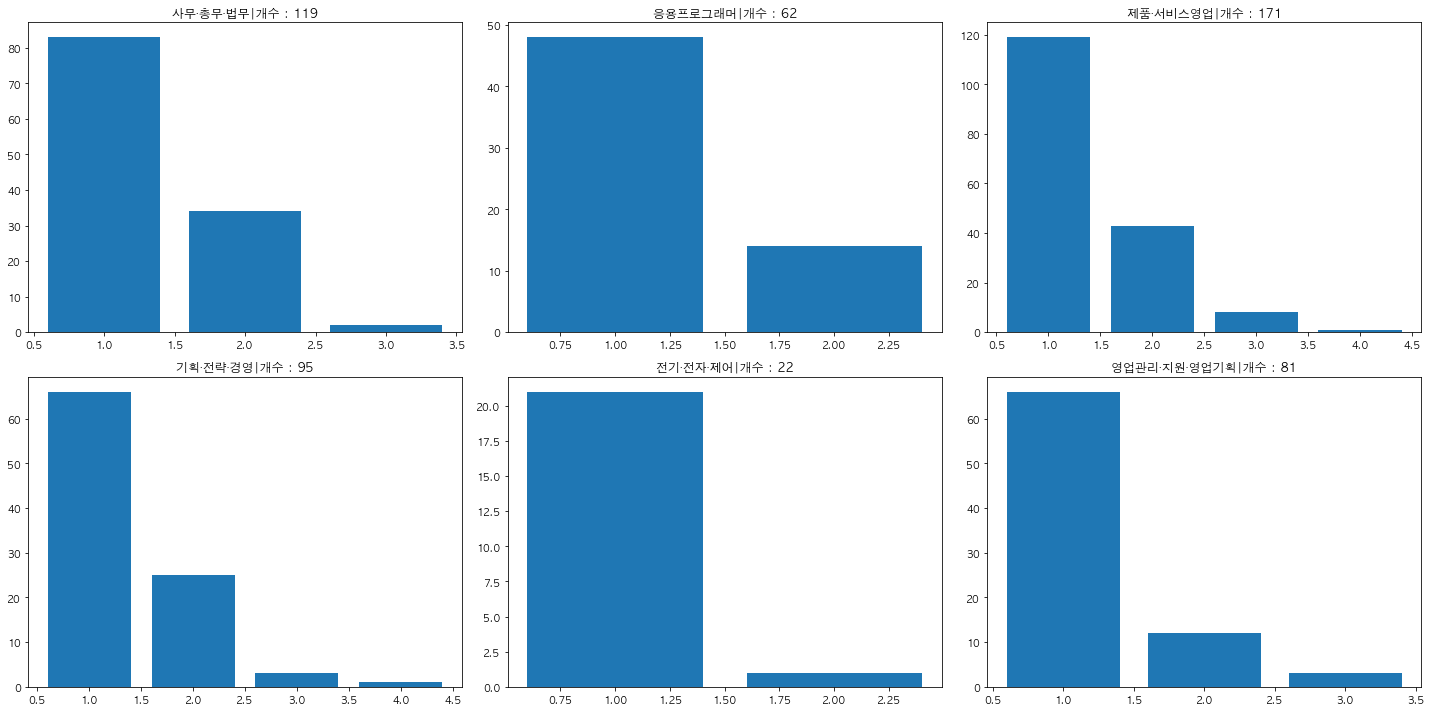

In [30]:
# 'act_society', 'act_volunteer', 'act_oversea', 
#     'act_intern', 'act_prize', 'act_club', 'lang']]
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_intern'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

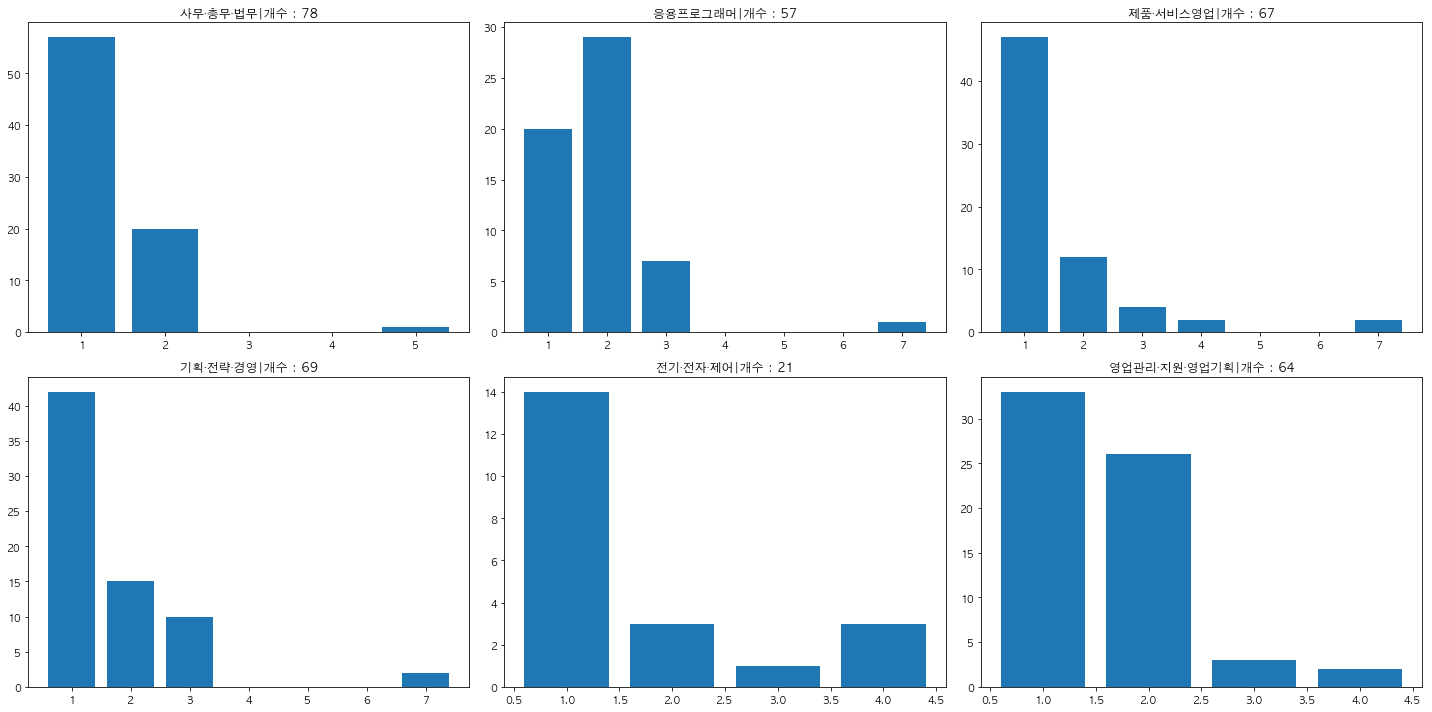

In [31]:
# 'act_society', 'act_volunteer', 'act_oversea', 
#     'act_intern', 'act_prize', 'act_club', 'lang']]
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_prize'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()

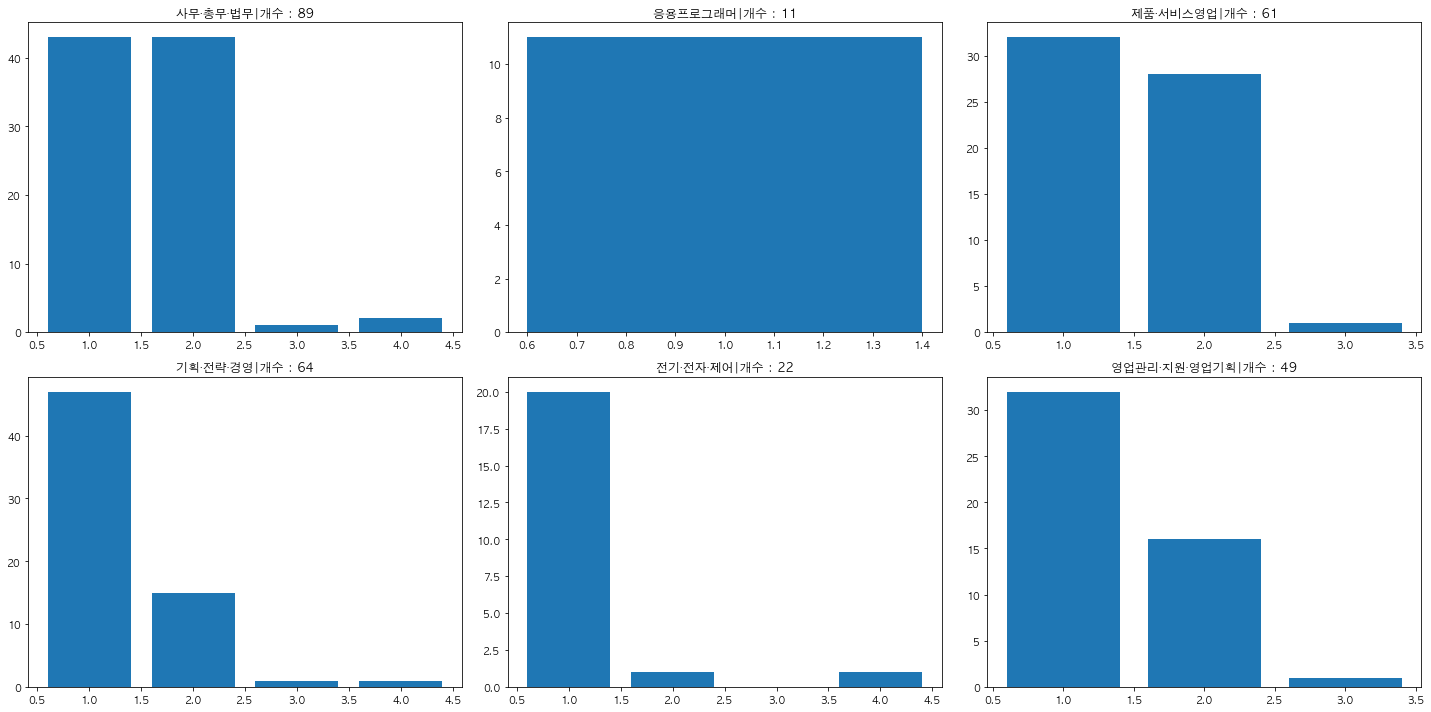

In [32]:
# 'act_society', 'act_volunteer', 'act_oversea', 
#     'act_intern', 'act_prize', 'act_club', 'lang']]
rows=2
cols=3
row=0
col=0
fig, ax = plt.subplots(rows, cols, figsize=(20,10))
names = ["사무·총무·법무","기획·전략·경영","응용프로그래머","전기·전자·제어","제품·서비스영업","영업관리·지원·영업기획"]
for name in names:
    tmp = df[(df['task']==name)]['act_club'].value_counts() 
    ax[row][col].bar(tmp.index, height = tmp)
    ax[row][col].set(title=name + '|개수 : ' + str(sum(tmp)))

    row+=1
    if row==rows:
        row=0
        col+=1
fig.tight_layout()
plt.show()